In [1]:
# terminology:
# obs_mask:  1 = observed,   0 = hole
# hole_mask: 1 = hole,       0 = not hole (observed)

# Absolutely lovely state of typesafety in this godforsaken ecosystem. We will use underscores a lot ...
# I will try to minimize usage of tf.cast

# we place emphasis on determinism
# only change one parameter (optimizer/dataset/hyperparams/overall architecture)in experiments


GLOBAL_RANDOM_SEED = 42

from datetime import datetime
import os, uuid
from tqdm import tqdm
import wandb
import pathlib
import subprocess, random

# import sys
# IN_COLAB = 'google.colab' in sys.modules

lockfile = pathlib.Path("dataset.lock")
if lockfile.exists():
    print("Download skipped (lockfile present).")

else:
    DOWNLOAD_SAMPLES, DOWNLOAD_THREADS = 5000, 8
    out = subprocess.check_output(
        ["rsync", "--no-motd", "--list-only", "rsync://176.9.41.242:873/biggan/portraits/"],  # ~17 sec
        text=True
    )
    files = sorted(line.split()[-1] for line in out.splitlines() if line.strip())

    ds_select_rng = random.Random(GLOBAL_RANDOM_SEED)
    ds_select_rng.shuffle(files)
    sel = files[:DOWNLOAD_SAMPLES]
    chunks = [sel[i::DOWNLOAD_THREADS] for i in range(DOWNLOAD_THREADS)]

    pathlib.Path("portraits").mkdir(exist_ok=True)
    procs = []
    for chunk in chunks:
        proc = subprocess.run([
            "rsync", "-avR", "--ignore-existing", "--files-from=-",
            "rsync://176.9.41.242:873/biggan/portraits/", "./portraits/"
        ], text=True, input="\n".join(chunk), check=True, stderr=subprocess.PIPE)
    for p in procs: p.wait()
    lockfile.touch()

WAN = False
if WAN:
    wandb.login(key='0705dccbb75c7facb5e8d3ff23f5772b0eb4488a')

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
os.environ["PYTHONHASHSEED"] = f"{GLOBAL_RANDOM_SEED}"
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "1"
import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
config.gpu_options.allow_growth = True
session = tf.compat.v1.InteractiveSession(config=config)
AUTOTUNE = tf.data.AUTOTUNE

import keras
import random
import matplotlib.pyplot as plt

tf.config.experimental.enable_op_determinism()
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)

Download skipped (lockfile present).


2025-08-21 20:10:59.487141: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755794459.507103   35931 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755794459.512862   35931 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755794459.527634   35931 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755794459.527660   35931 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755794459.527662   35931 computation_placer.cc:177] computation placer alr

In [42]:
EPOCHS_TO_TRAIN = 200
num_samples = 1000

BATCH_SIZE = 32

H = 64
W = 64
C = 3

P = 8
assert H == W
assert H % P == 0

heads = 8

D_model = 1024
D_head = 128
D_fcn = 1024
num_layers = 8
N = (H * W) // (P * P)

MASK_MAX_SIZE = 20
MASK_MIN_SIZE = 20
assert MASK_MAX_SIZE < H / 2

optimizer = keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-2)
# optimizer = keras.optimizers.Adam(learning_rate=1e-4)

# keras.mixed_precision.set_global_policy("mixed_bfloat16")
FLOAT = tf.float32

In [14]:
def viz_img(image):
    image = tf.cast(image, tf.float32)
    plt.imshow(tf.squeeze(image).numpy(), cmap="gray")
    plt.colorbar()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    plt.text(
        0.99,
        0.01,
        timestamp,
        ha="right",
        va="bottom",
        transform=plt.gca().transAxes,
        fontsize=12,
        color="white",
        alpha=0.9,
        bbox=dict(boxstyle="square,pad=0.1", facecolor="black", alpha=0.3),
    )
    plt.show()


def viz_mask(mask):
    plt.imshow(tf.squeeze(mask).numpy(), cmap="gray", vmin=0, vmax=1)
    plt.colorbar()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    plt.text(
        0.99,
        0.01,
        timestamp,
        ha="right",
        va="bottom",
        transform=plt.gca().transAxes,
        fontsize=12,
        color="white",
        alpha=0.9,
        bbox=dict(boxstyle="square,pad=0.1", facecolor="black", alpha=0.3),
    )
    plt.show()


def viz_grid(batch: tf.Tensor, max_samples: int = 4):
    batch_size: int = batch.shape[0]  # type: ignore
    num = min(batch_size, max_samples)
    fig, axes = plt.subplots(nrows=1, ncols=num, figsize=(15, 15), dpi=300)
    if num == 1:
        axes = [axes]
    for i in range(num):
        # Original image
        axes[i].imshow(
            tf.clip_by_value(
                tf.cast(batch[i], dtype=tf.float32), 0, 1  # type: ignore
            ).numpy(),  # type: ignore
            cmap='gray'
        )
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


def random_obs_mask(canvas_height, canvas_width, min_size, max_size, idx):
    seed = tf.stack([tf.cast(GLOBAL_RANDOM_SEED, tf.int32), tf.cast(idx, tf.int32)])
    sizes = tf.random.stateless_uniform(
        [2], minval=min_size, maxval=max_size + 1, dtype=tf.int32, seed=seed
    )
    w = sizes[0]
    h = sizes[1]
    x = tf.random.stateless_uniform(
        [], minval=0, maxval=canvas_width - w + 1, dtype=tf.int32, seed=seed + 1
    )
    y = tf.random.stateless_uniform(
        [], minval=0, maxval=canvas_height - h + 1, dtype=tf.int32, seed=seed + 2
    )

    mask = tf.ones([canvas_height, canvas_width], dtype=FLOAT)

    # TensorFlow-friendly indexing
    ys = tf.range(y, y + h)
    xs = tf.range(x, x + w)
    yy, xx = tf.meshgrid(ys, xs, indexing='ij')
    indices = tf.stack([tf.reshape(yy, [-1]), tf.reshape(xx, [-1])], axis=1)

    updates = tf.zeros([h * w], dtype=FLOAT)
    mask = tf.tensor_scatter_nd_update(mask, indices, updates)
    mask = tf.expand_dims(mask, -1)
    mask.set_shape([canvas_height, canvas_width, 1])
    return mask


# we previously did return a tuple with the second param being an "is_valid" boolean,
# but we mostly should work with clean curated datasets (and preprocessing is not our job)
# doing this ensures we can benefit from cheap .cardinality() calls instead of enumerating
# the whole dataset to find actual cardinality to then use in downstream tasks (split/etc)
# tl;dr: it's not every day you get to work with datasets that don't maintain a consistent resolution
def load_strict(file_path, expected_shape):
    img_bytes = tf.io.read_file(file_path)
    img = tf.image.decode_image(img_bytes, channels=expected_shape[2], expand_animations=False)
    img = tf.cast(img, tf.float32) / 255.0

    # Raise in TF if shape mismatches.
    actual_shape = tf.shape(img)
    tf.debugging.assert_equal(
        actual_shape,
        tf.constant(expected_shape, dtype=tf.int32),
        message=f"Shape mismatch for {file_path}"
    )

    img.set_shape(expected_shape)
    return img

Dataset has 1000 samples
img (64, 64, 3) mask (64, 64, 1)
Trn,Tst,Val: 800 100 100
Trn,Tst,Val batches: 25 4 4


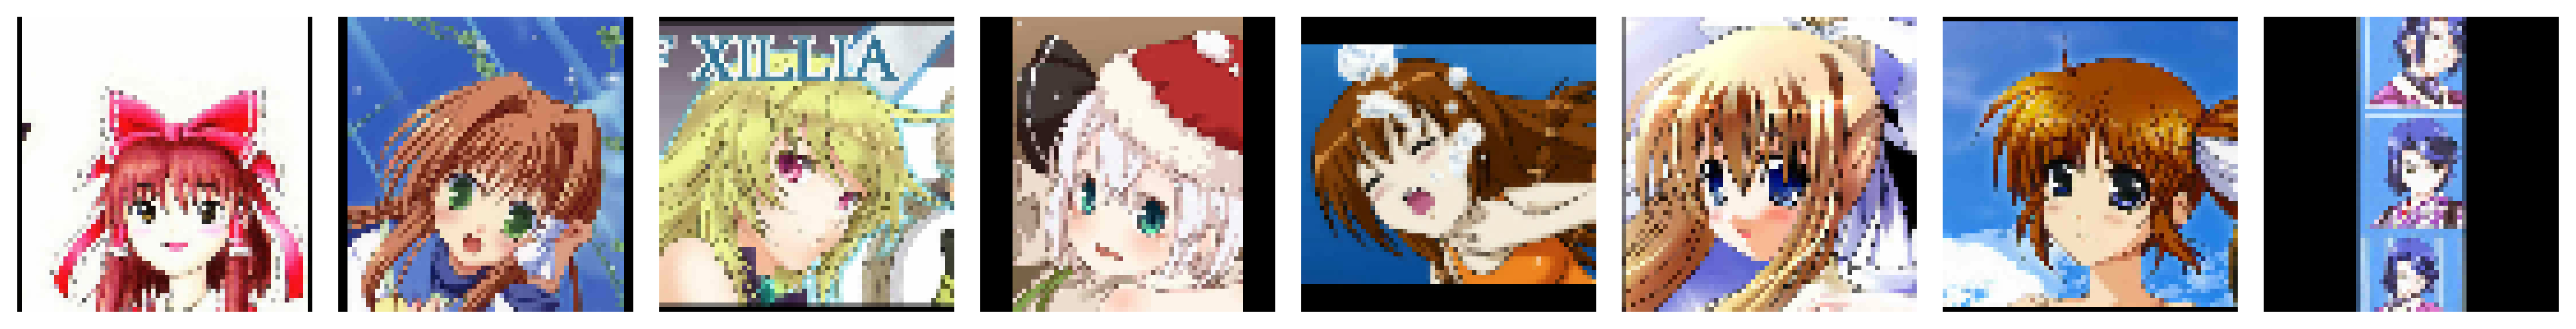

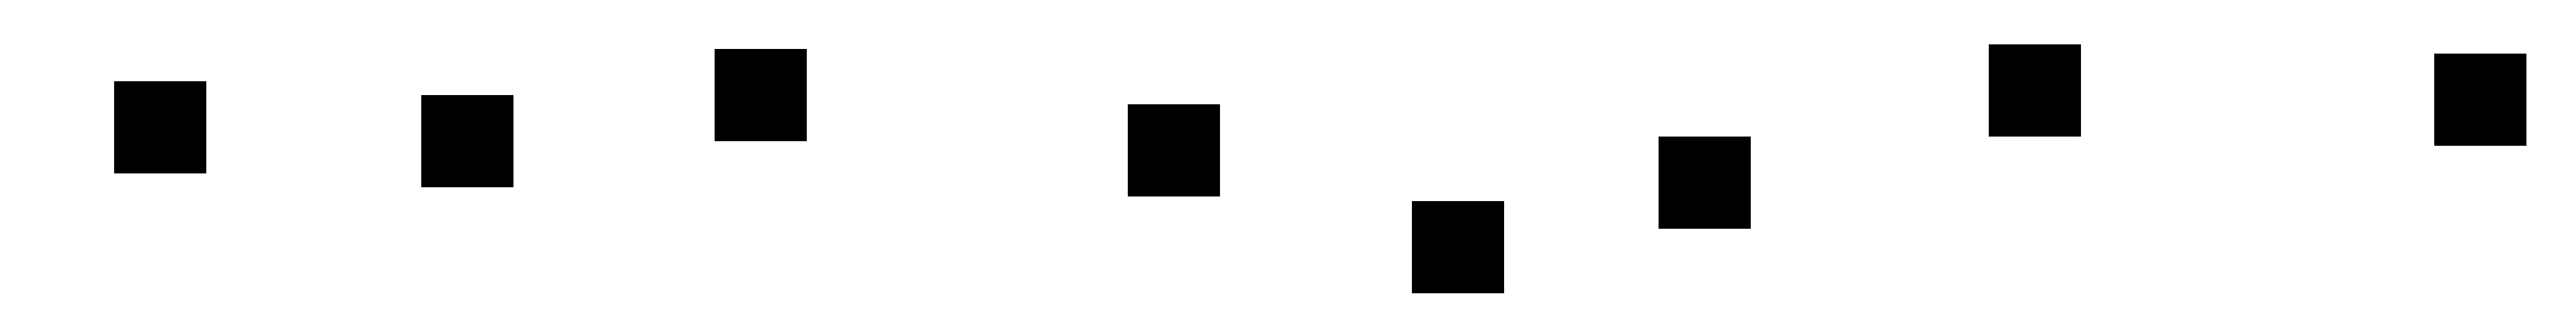

In [32]:
ds_shape_advertised = (512, 512, 3)
dataset_path = "/mnt/Data/ML/datasets/portraits"

all_files = [
    os.path.join(dataset_path, f)
    for f in os.listdir(dataset_path)
    if f.endswith((".jpg", ".png"))
]
dsrng = random.Random(GLOBAL_RANDOM_SEED)
dsrng.shuffle(all_files)
selected_files = all_files[:num_samples]
dataset = tf.data.Dataset.from_tensor_slices(selected_files)

dataset = dataset.map(
    lambda img: load_strict(img, ds_shape_advertised),
    num_parallel_calls=AUTOTUNE,
)

dataset = dataset.map(
    lambda img: tf.image.resize(img, (H, W)),
    num_parallel_calls=AUTOTUNE,
)

if C == 1 and ds_shape_advertised[2] == 3:
    dataset = dataset.map(
        lambda img: tf.image.rgb_to_grayscale(img),
        num_parallel_calls=AUTOTUNE,
    )

dataset = dataset.enumerate()
dataset = dataset.map(
    lambda idx, img: (img, random_obs_mask(H, W, MASK_MIN_SIZE, MASK_MAX_SIZE, idx)),
    num_parallel_calls=AUTOTUNE  # must be single-threaded for deterministic order
)
ds_count = dataset.cardinality().numpy()
print(f"Dataset has {ds_count} samples")
for img, mask in dataset.take(1):
    print("img", img.shape, "mask", mask.shape)

train_count = int(ds_count * 0.8)
test_count = int(ds_count * 0.1)
val_count = ds_count - train_count - test_count

train_ds = dataset.take(train_count).batch(BATCH_SIZE)
test_ds = dataset.skip(train_count).take(test_count).batch(BATCH_SIZE)
val_ds = dataset.skip(train_count + test_count).take(val_count).batch(BATCH_SIZE)

train_batches = -(train_count // -BATCH_SIZE)
test_batches = -(test_count // -BATCH_SIZE)
val_batches = -(val_count // -BATCH_SIZE)

print("Trn,Tst,Val:", train_count, test_count, val_count)
print("Trn,Tst,Val batches:", train_batches, test_batches, val_batches)
viz_grid(next(iter(train_ds.take(1).map(lambda img, mask: img))), 8)  # type: ignore
viz_grid(next(iter(train_ds.take(1).map(lambda img, mask: mask))), 8)  # type: ignore

In [38]:
def extract_patches(image: tf.Tensor) -> tf.Tensor:
    """R^{BS x H x W x C} -> R^{BS x N x P^2 x C}"""

    patches: tf.Tensor = tf.image.extract_patches(
        images=image,
        sizes=[1, P, P, 1],
        strides=[1, P, P, 1],
        rates=[1, 1, 1, 1],
        padding="VALID",
    )
    bs, h_prime, w_prime, _ = tf.unstack(tf.shape(patches))

    # Reshape patches to [BS, H' * W', P*P, C]
    patches = tf.reshape(patches, [bs, h_prime * w_prime, P * P, -1])

    return patches


def patches_to_imgs(patches: tf.Tensor) -> tf.Tensor:
    """R^{BS x N x P.P.C} -> R^{BS x H x W x C}"""
    bs = tf.shape(patches)[0]
    grid_size = H // P  # same as W // P
    patches = tf.reshape(patches, [bs, grid_size, grid_size, P, P, C])
    patches = tf.transpose(patches, perm=[0, 1, 3, 2, 4, 5])
    image = tf.reshape(patches, [bs, grid_size * P, grid_size * P, C])

    return image


sample_img, sample_mask = next(iter(dataset.take(1)))
sample_img = tf.expand_dims(sample_img, 0)
tf.assert_equal(patches_to_imgs(extract_patches(sample_img)), sample_img)


def create_attention_mask(obs_mask_bool: tf.Tensor):
    """R^{BS x H x W} -> R^{BS x N x N}"""
    # TF does not support native min pooling.
    # The mask shown is OBSERVATION MASK meaning 0 means missing.

    bs = tf.shape(obs_mask_bool)[0]
    mask_pooled = tf.nn.max_pool2d(
        tf.cast(tf.logical_not(obs_mask_bool), dtype=tf.int8),
        ksize=[P, P],
        strides=[P, P],
        padding="VALID",
    )
    mask_pooled = tf.logical_not(tf.cast(mask_pooled, tf.bool))
    # viz_mask(mask_pooled)
    mask_pooled = tf.reshape(mask_pooled, [bs, N])
    mask_expanded = tf.expand_dims(mask_pooled, axis=1)  # (BS, 1, N)
    mask_expanded = tf.tile(mask_expanded, [1, N, 1])  # (BS, N, N)
    attn_mask = tf.where(
        mask_expanded,
        tf.constant(0.0, dtype=FLOAT),  # zero penalty
        tf.constant(-float("inf"), dtype=FLOAT),  # inf penalty
    )
    return attn_mask


def apply_obs_mask(image: tf.Tensor, obs_mask_float: tf.Tensor) -> tf.Tensor:
    return tf.multiply(image, obs_mask_float)


def reconstruct(
        original: tf.Tensor, inpainted: tf.Tensor, obs_mask_float: tf.Tensor
) -> tf.Tensor:
    obs_mask_bool = tf.cast(obs_mask_float, dtype=tf.bool)
    return tf.add(
        tf.multiply(tf.cast(obs_mask_bool, FLOAT), original),
        tf.multiply(tf.cast(tf.logical_not(obs_mask_bool), FLOAT), inpainted),
    )

# sample = next(iter(train_ds.unbatch().take(1)))
# print(sample[0].dtype)
# viz_img(sample[0])
# viz_mask(sample[1])

In [39]:
initializer = keras.initializers.GlorotUniform(seed=GLOBAL_RANDOM_SEED)

commonDense = {"dtype": FLOAT, "kernel_initializer": initializer}


class PatchEmbedding(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.positional_embedding = None
        self.proj = keras.layers.Dense(D_model, **commonDense)  # (P² * C) -> D_model

    def build(self, input_shape):
        self.positional_embedding = self.add_weight(
            shape=(N, D_model), initializer=initializer, name="pos_embed"
        )

    def call(self, patches_flat: tf.Tensor):
        # R^{BS x N x (P^2 . C)} -> R^{BS x N x D_model}
        X = self.proj(patches_flat)
        X += self.positional_embedding
        return X


class KMultiHeadAttention(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.mha = keras.layers.MultiHeadAttention(
            num_heads=heads,
            key_dim=D_head,
            output_shape=D_model,
            use_bias=True,
            dtype=FLOAT,
        )

    def call(self, X, attn_mask):
        """R^{BS x N x D_model}, R^{BS x N x N} -> R^{BS x N x D_model}"""
        return self.mha(X, X, attention_mask=attn_mask)


class TransformerBlock(keras.layers.Layer):
    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.attn = KMultiHeadAttention()
        self.norm1 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.norm2 = keras.layers.LayerNormalization(dtype=FLOAT)
        self.ffn = keras.Sequential(
            [
                keras.layers.Dense(
                    D_fcn, activation="relu", **commonDense
                ),  # Switched to ReLU
                keras.layers.Dense(D_model, **commonDense),
            ]
        )

    def call(self, X, A):
        """R^{BS x N x D_model} -> R^{BS x N x D_model}"""

        A = tf.cast(A, dtype=tf.bool)
        # NEW : pre norm blocks
        X_norm = self.norm1(X)
        X_attn = self.attn(X_norm, A)
        X = X + X_attn
        X_norm2 = self.norm2(X)
        X_ffn = self.ffn(X_norm2)
        X = X + X_ffn
        return X


# class Refiner(keras.layers.Layer):
#     def __init__(self):
#         super().__init__(dtype=FLOAT)
#         self.conv1 = keras.layers.Conv2D(64, 3, padding="same", activation="relu")
#         self.conv2 = keras.layers.Conv2D(
#             128, 3, dilation_rate=2, padding="same", activation="relu"
#         )
#         self.conv3 = keras.layers.Conv2D(3, 3, padding="same")
#
#     def call(self, X):
#         """R^{BS x H x W x C} -> R^{BS x H x W x C}"""
#         residual = X
#         X = self.conv1(X)
#         X = self.conv2(X)
#         X = self.conv3(X)
#         return X + residual


class TransformerDecoder(keras.layers.Layer):
    """R^{BS x N x D_model} -> R^{BS x N x P*P*C}"""

    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.proj1 = keras.layers.Dense(D_model, activation="gelu", **commonDense)
        self.proj2 = keras.layers.Dense(P * P * C, activation="sigmoid", **commonDense)

    def call(self, X):
        BS = tf.shape(X)[0]
        X = self.proj1(X)
        X = self.proj2(X)
        return tf.reshape(X, (BS, N, P, P, C))


class ImageInpaintingTransformer(keras.Model):
    """outputs R ^ {BS x H x W x C}"""

    def __init__(self):
        super().__init__(dtype=FLOAT)
        self.embed = PatchEmbedding()
        self.transformer_blocks = [TransformerBlock() for _ in range(num_layers)]
        self.decoder = TransformerDecoder()
        # self.refiner = Refiner()

    def build(self, input_shape):
        # bs = input_shape[0]
        # dummy_images = tf.zeros((BS, H, W, C), dtype=FLOAT)  # THIS WASTED 40 MINUTES
        self.call(*next(iter(val_ds.take(1))))
        self.built = True

    def call(self, image, obs_mask_float):
        image = tf.multiply(image, obs_mask_float)
        obs_mask_bool = tf.cast(obs_mask_float, dtype=tf.bool)
        # viz_img(image[0])
        patches = extract_patches(image)
        AttnMask = create_attention_mask(obs_mask_bool)
        # viz_img(AttnMask[0])

        BS = tf.shape(patches)[0]
        patches_flat = tf.reshape(patches, [BS, N, P ** 2 * C])
        # tf.print(tf.shape(patches_flat))
        X = self.embed(patches_flat)
        for block in self.transformer_blocks:
            X = block(X, AttnMask)

        decoded = self.decoder(X)
        return patches_to_imgs(decoded)


model = ImageInpaintingTransformer()
model.build((BATCH_SIZE, H, W, C))
# model.compute_output_shape((BATCH_SIZE, H, W, C))
model.summary()

run_id = uuid.uuid4()
print(run_id)
session_epochs = 0
session_steps = 0


def cost_func(
        y_true: tf.Tensor, y_pred: tf.Tensor, obs_mask_float: tf.Tensor
) -> tf.RaggedTensor:
    # errors = tf.square(tf.subtract(y_true, y_pred))
    errors = tf.abs(tf.subtract(y_true, y_pred))
    hole_mask = 1.0 - obs_mask_float  # type: ignore

    hole_loss = tf.reduce_sum(errors * hole_mask) / (tf.reduce_sum(hole_mask) + 1e-8)
    valid_loss = tf.reduce_sum(errors * obs_mask_float) / (tf.reduce_sum(obs_mask_float) + 1e-8)

    return 2 * hole_loss + 1 * valid_loss


def train_step(img: tf.Tensor, mask: tf.Tensor) -> tf.RaggedTensor:
    with tf.GradientTape() as tape:
        pred = model(img, mask, training=True)
        loss = cost_func(img, pred, mask)
    gradients = tape.gradient(loss, model.trainable_variables)
    if gradients is None:
        raise RuntimeError()
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss


def val_step(image: tf.Tensor, mask: tf.Tensor) -> tf.RaggedTensor:
    reconstructed_img = model(image, mask, training=False)
    loss = cost_func(image, reconstructed_img, mask)
    return loss


def run_epoch(ds: tf.data.Dataset, step_fn, total_batches, desc):
    total_loss = 0.0
    steps = 0
    pbar = tqdm(ds, desc=desc, unit="step", total=total_batches)
    for x, y in pbar:
        loss = step_fn(x, y).numpy()
        total_loss += loss
        steps += 1
        pbar.set_postfix(loss=f"{float(loss):.4f}")
    return total_loss / steps


import inspect
import textwrap

loss_source = textwrap.dedent(inspect.getsource(cost_func))
run = None
if WAN:
    run = wandb.init(
        entity="navidmafi-semnan-university",
        project="T1",
        dir="__wandb_logs",
        config={
            "optimizer": optimizer.get_config(),
            "num_samples": num_samples,
            "D_model": D_model,
            "D_head": D_head,
            "D_fcn": D_fcn,
            "H": H,
            "W": W,
            'P': P,
            "heads": heads,
            'Float': str(FLOAT),
            "num_layers": num_layers,
            "batch_size": BATCH_SIZE,
            "loss": loss_source
        },
    )

Model: "image_inpainting_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ patch_embedding                 │ ?                      │       263,168 │
│ (PatchEmbedding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block               │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_1             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_2             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_3             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_4             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_5             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_6             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_7             │ ?                      │     6,301,696 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder             │ ?                      │     1,246,400 │
│ (TransformerDecoder)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,923,136 (198.07 MB)

 Trainable params: 51,923,136 (198.07 MB)

 Non-trainable params: 0 (0.00 B)

959e48fe-c1b0-40b9-8c3e-d1b53669859b


In [ ]:
# model.load_weights("best_run.keras")
# model.save(name)

In [43]:
assert isinstance(session_epochs, int)
assert isinstance(session_steps, int)
print(
    f"Starting training for {EPOCHS_TO_TRAIN - session_epochs} "
    f"epochs (already did {session_epochs})"
)

best_val_loss = float("inf")
best_epoch = -1
for _ in range(EPOCHS_TO_TRAIN - session_epochs):
    train_loss = run_epoch(train_ds, train_step, train_batches, f"Epoch {session_epochs + 1}")
    val_loss = run_epoch(val_ds, val_step, val_batches, f"Epoch {session_epochs + 1} Validation")

    if run:
        run.log({'val/loss': val_loss, 'train/loss': train_loss, 'epoch': session_epochs})

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = session_epochs + 1
        model.save("best_run.keras")

    session_epochs += 1

Starting training for 100 epochs (already did 100)


Epoch 200 Validation: 100%|██████████| 4/4 [00:01<00:00,  2.83step/s, loss=1.5902]


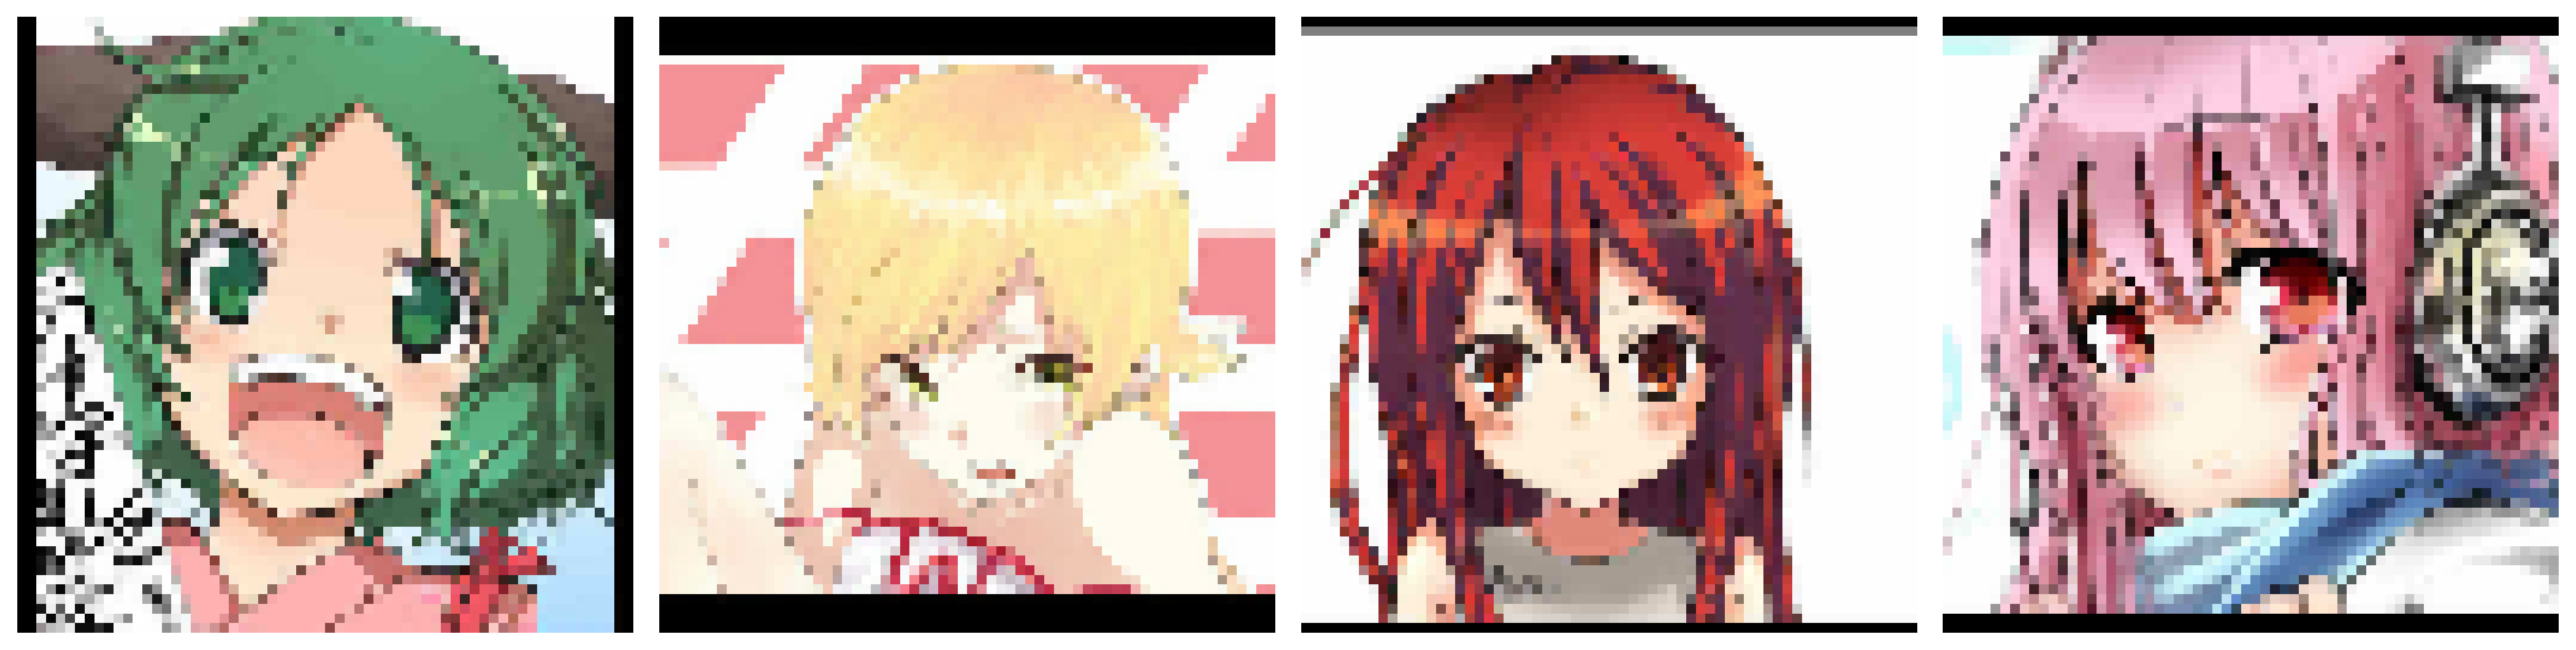

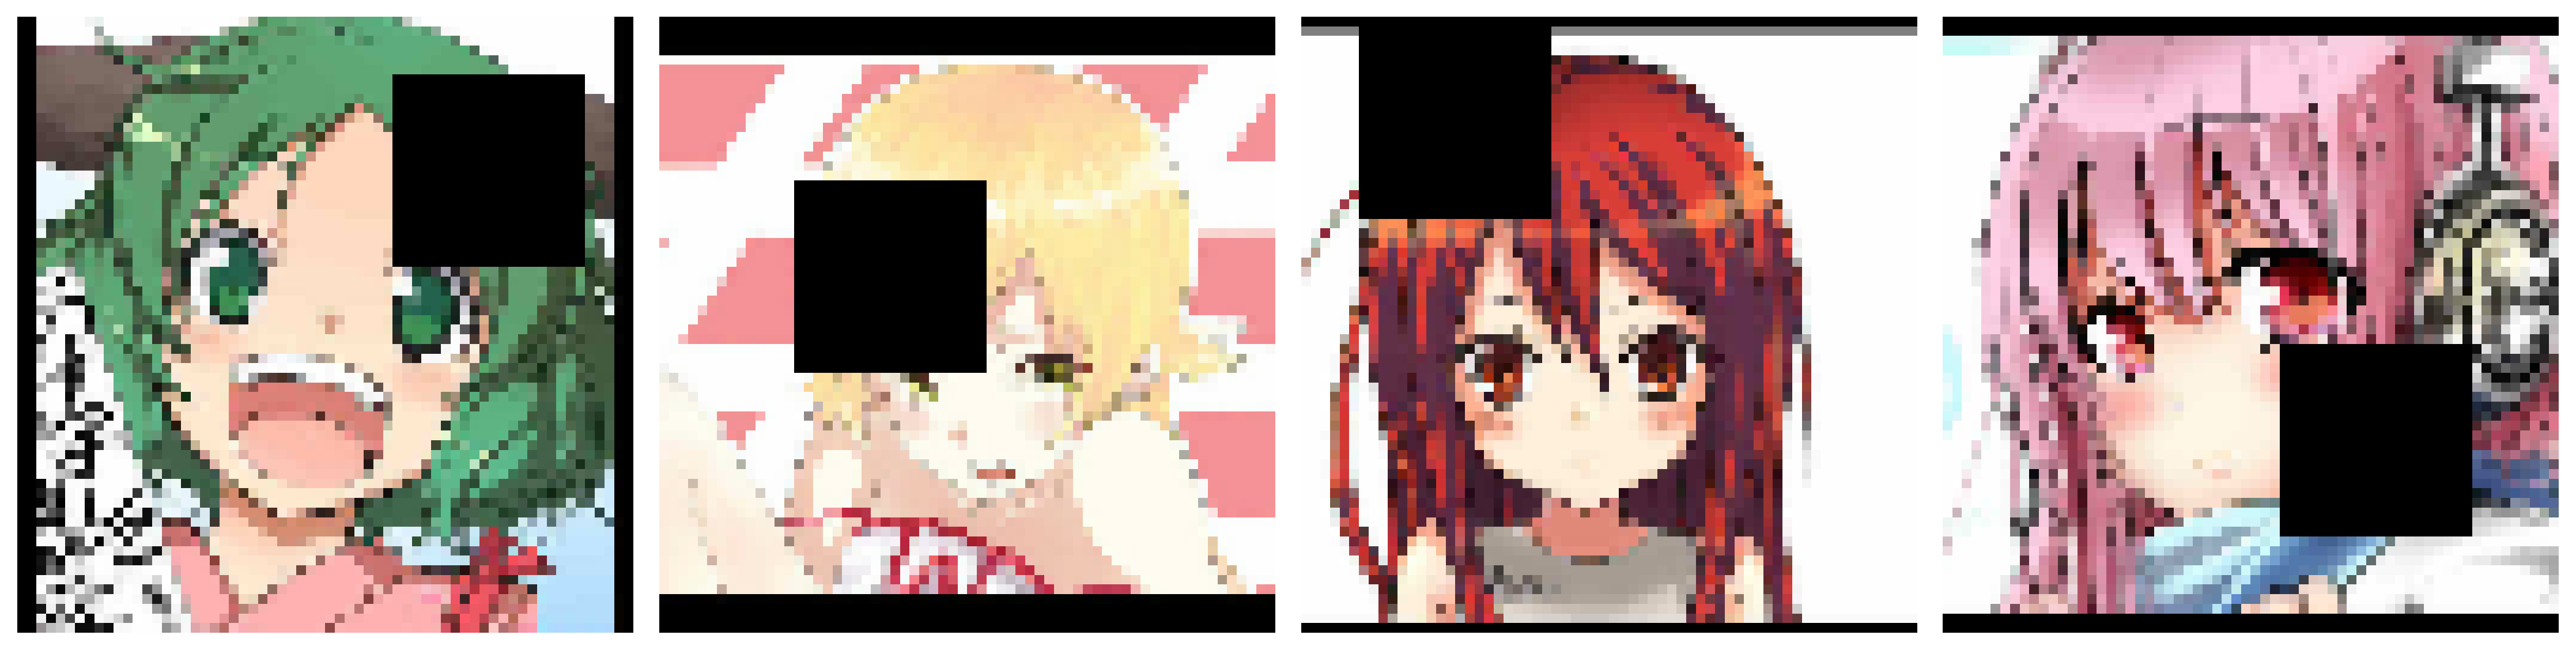

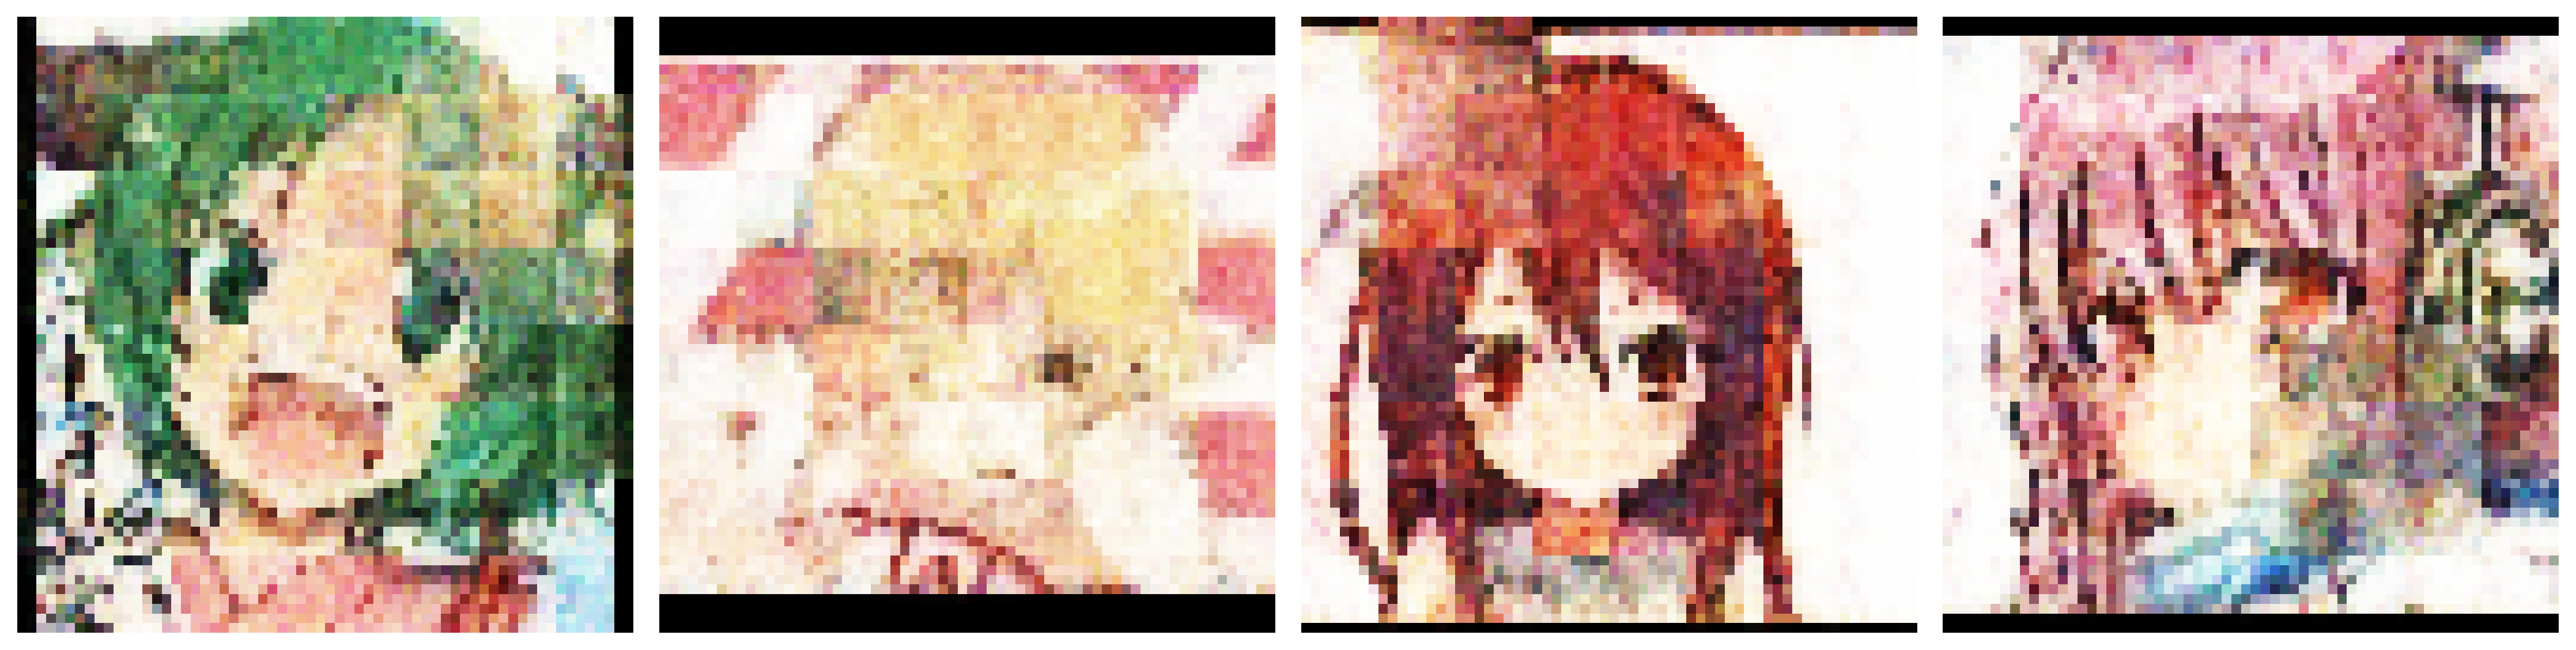

PSNR 17.878912
SSIM 0.6650491


In [44]:
# sample_img, sample_obs_mask_float = next(iter(train_ds.take(1)))
sample_img, sample_obs_mask_float = next(iter(test_ds.take(1)))
viz_grid(sample_img)
viz_grid(apply_obs_mask(sample_img, sample_obs_mask_float))
model_out = model(sample_img, sample_obs_mask_float)
reconstructed = reconstruct(sample_img, model(sample_img, sample_obs_mask_float), sample_obs_mask_float)
# viz_grid(reconstructed)
viz_grid(model_out)
print("PSNR", tf.reduce_mean(tf.image.psnr(sample_img, model_out, max_val=1.0)).numpy())
print("SSIM", tf.reduce_mean(tf.image.ssim(sample_img, model_out, max_val=1.0)).numpy())